# CASE 1: **Double-well potential**

equations of double-well

### 1. Inizialization

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann as kB
from numpy.random import randn as gauss
from numpy.random import rand as uniform

case_study = '1D_double-well'

### 2. Generate Trajectories


Here it's defined the function that simulates the motion of the Brownian particle in the force field. Particularly, in this case of study, we consider a Brownian particle in a double well trap. The trajectory of the particle depends on two target parameters: the equilibrium distance L and the potential energy barrier height H.

Comments:

1. The function that simulates the trajectories is *simulate_trajectory*.
2. Lambda functions scale_inputs, rescale_inputs, scale_targets, and rescale_targets must also be defined. For the best performance of the learning, the rescaling of both the inputs and targets should lead to values of order 1.

In [2]:
## define parameters
normal_values = True

In [3]:
if normal_values == True:
    
    ### follows the parameters used in DeepCalib
    
    ### Physical parameters 
    R = 1e-7                                # Radius of the Brownian particle [m]
    eta = 0.001                             # Viscosity of the medium [kg m^-1 s^-1]
    T = 300                                 # Temperature [K]
    L0 = 2e-6                               # Reference distance from middle to one minimum [m]
    H0 = kB*300                             # Barrier height [Joule]
    gamma0 = 6 * np.pi * eta * R            # Reference friction coefficient [kg s^-1]

    ### Simulation parameters
    N = 1000                   # Number of samples of the trajectory
    Dt = 1e-2                  # Timestep 
    oversampling = 5           # Simulation oversampling
    offset = 1000              # Number of equilibration timesteps
    batch_size = 32            # Number of trajectories

else:
    ### larger values
    
    ### Physical parameters 
    R = 1e-7                                # Radius of the Brownian particle [m]
    eta = 0.001                             # Viscosity of the medium [kg m^-1 s^-1]
    T = 300                                 # Temperature [K]
    L0 = 2e-6                               # Reference distance from middle to one minimum [m]
    H0 = kB*300                             # Barrier height [Joule]
    gamma0 = 6 * np.pi * eta * R            # Reference friction coefficient [kg s^-1]

    ### Simulation parameters
    N = 1000                   # Number of samples of the trajectory
    Dt = 1e-2                  # Timestep 
    oversampling = 5           # Simulation oversampling
    offset = 1000              # Number of equilibration timesteps
    batch_size = 32            # Number of trajectories



In [4]:
### Define functions to scale and rescale inputs
scale_inputs = lambda x: x * 1e+6                    # Scales input trajectory to order 1
rescale_inputs = lambda scaled_x: scaled_x * 1e-6    # Rescales input trajectory to physical units

### Define function to scale and rescale targets
scale_targets = lambda L, H: [L/L0 -1, np.log(H / H0)]                        # Scales targets to order 1
rescale_targets = lambda scaled_L, scaled_H: [(1 + scaled_L)*L0*1e6, 
                                              np.exp(scaled_H) * H0/kB/300] # Inverse of targets_scaling

def simulate_trajectory(batch_size=batch_size, 
                        T=T,
                        H0=H0,
                        L0=L0,
                        gamma0=gamma0,
                        N=N, 
                        Dt=Dt, 
                        oversampling=oversampling, 
                        offset=offset):#, 
                        #scale_inputs=scale_inputs, 
                        #scale_targets=scale_targets):
    
    ### Randomize trajectory parameters
    L = L0 * (uniform(batch_size)+.5) 
    H = H0 * 10**(uniform(batch_size)*1.75 - .75)       # Generates random values for computing the stiffness
    gamma = gamma0 * (uniform(batch_size) * .1 + .95)   # Marginal randomization of friction coefficient to tolarate small changes

    ### Simulate
    dt = Dt / oversampling                 # time step of the simulation
    x = np.zeros((batch_size, N))          # initialization of the x array
    k0 = 4*H/L**2 
    k1 = 4*H/L**4
    D = kB * T / gamma                     # diffusion coefficient
    C1 = +k0 / gamma * dt
    C2 = -k1 / gamma * dt                  # drift coefficient of the Langevin equation
    C3 = np.sqrt(2 * D * dt)               # random walk coefficient of the Langevin equation
    X = x[:, 0]
    n = 0
    
    for t in range(offset):                      # Offset (for some prerun before running)
        X = X + C1 * X + C2 * X**3 + C3 * gauss(batch_size)
        #X = X - (2 * X**3) + (12 * X**2) - (18 * X) + 3 + (C3 * gauss(batch_size))
        
    for t in range(N * oversampling):            # Simulation                
        X = X + C1 * X + C2 * X**3 + C3 * gauss(batch_size)
        #X = X - (2 * X**3) + (12 * X**2) - (18 * X) + 3 + (C3 * gauss(batch_size))
        if t % oversampling == 0:                # We save every oversampling^th values 
            x[:, n] = X 
            n += 1

    inputs = scale_inputs(x)
    inputs_real = x
    targets = np.swapaxes(scale_targets(*[L, H]),0,1)
    target_real = np.swapaxes([L*1e6, H/kB/300],0,1)

    return inputs, inputs_real, targets, target_real

### 3. Plot Trajectory Simulation

In [5]:
def plot_sample_trajectories(simulate_trajectory, number_of_trajectories_to_show):
    """
    
    Inputs:   
    
    simulate_trajectory:                 trajectroy generator function
    number_of_trajectories_to_show:      number of trajectories to be plotted as sample  
        
    Output:
    
    This function does not return any outputs, it only plots some sample trajectories to preview the generator function
   
    """ 
    import matplotlib.pyplot as plt
    inputs, targets = simulate_trajectory(number_of_trajectories_to_show)
    
    if len(inputs.names)>1:
        for scaled_values, scaled_targets, target_values in zip(inputs.scaled_values, targets.scaled_values, targets.values):
            plt.figure(figsize=(20, 5))    
            number_subplots = len(inputs.names)
            for subplot in range(number_subplots):
                plt.subplot(1, number_subplots, subplot+1)
                plt.plot(scaled_values[subplot])
                plt.xlabel('timestep', fontsize=18)
                plt.ylabel(inputs.scalings[subplot], fontsize=18)   

            title_text = 'Parameters: ' 
            for parameter in range(len(target_values)):
                title_text +=  ', ' + targets.names[parameter] + ' = ' + '%1.2e' % target_values[parameter]
            plt.title(title_text, fontsize=18)  

    else:
        for scaled_values, scaled_targets, target_values in zip(inputs.scaled_values, targets.scaled_values, targets.values):
            plt.figure(figsize=(20, 5))
            plt.plot(scaled_values)
            plt.xlabel('timestep', fontsize=18)
            plt.ylabel(inputs.scalings[0], fontsize=18)
            title_text = 'Parameters: ' 
            if len(targets.names)>1:
                for parameter in range(len(targets.names)):
                    title_text +=  ', ' + targets.names[parameter] + ' = ' + '%1.2e' % target_values[parameter]
                plt.title(title_text, fontsize=18)  
            else:
                plt.title(title_text + ' ' + targets.names[0] + ' = ' + '%1.2e' % target_values , fontsize=18)  

In [10]:
### Show some examples of simulated trajectories
number_of_trajectories_to_show= 10
plot_sample_trajectories(simulate_trajectory, number_of_trajectories_to_show)

0.002


AttributeError: 'numpy.ndarray' object has no attribute 'names'

0.002
(1000,)


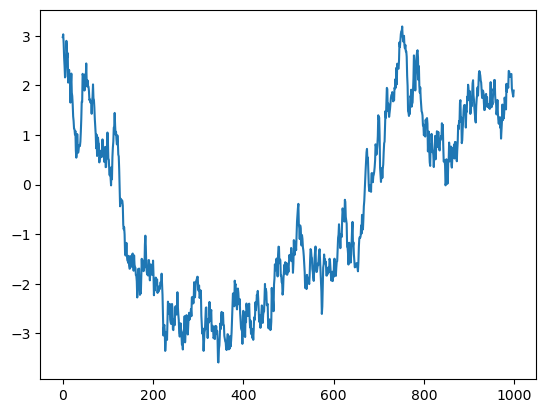

In [31]:
trajectory, target, target_real = simulate_trajectory(batch_size)
print(trajectory[0,:].shape)
plt.plot(trajectory[0,:])

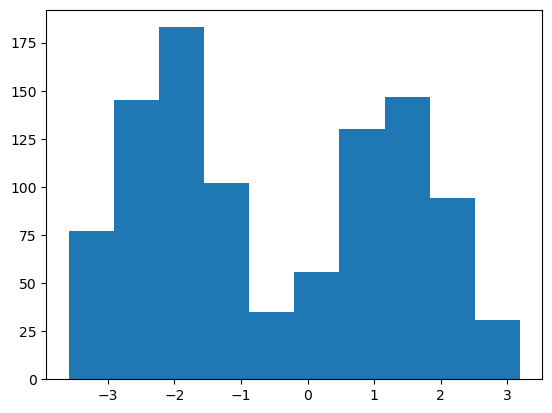

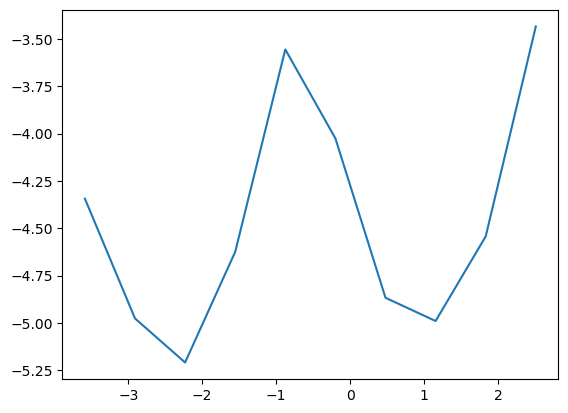

In [32]:
a=plt.hist(trajectory[0])#x[0])
plt.show()
a_1,a_2 = a[0],a[1]

plt.plot(a_2[:-1],-np.log(a_1))
plt.show()

### 4. COMPILE Deep Neural Network

The parameters of the deep learning network are defined and the network created. The summary of the network is printed where the output shape and number of parameters for each layer can be visualized.

Comments:

1. The parameter input_shape determines the shape of the input sequence, given by the number of time-steps times the number of samples in each input sequence. Make sure your input shape dimensions match the length of the input trajectory, in this example 2 x 500 = 1000.
2. The parmameter conv_layers_dimensions determines the number and size of LSTM layers.
3. The parameter number_of_outputs determines the number of outputs, i.e. the number of force field parameters to be estimated.

#### GRU with attention

CREATE MODEL

In [5]:
from src_models import models_DNN, train_DNN, test_DNN

In [7]:
### Define parameters of the deep learning network
input_shape = (20, 50)      
lstm_layers_dimensions = (250, 50)
number_of_outputs = 2

DNN = 'GRU'
attention = True

### Create deep learning network
network = models_DNN.create_deep_learning_network(input_shape, lstm_layers_dimensions, number_of_outputs, 
                                                      DNN,
                                                      attention)

### Print deep learning network summary
network.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 50)]          0         
                                                                 
 gru_0 (GRU)                 (None, 20, 250)           226500    
                                                                 
 gru_1 (GRU)                 (None, 20, 50)            45300     
                                                                 
 attention_1 (Attention)     (None, 50)                70        
                                                                 
 output (Dense)              (None, 2)                 102       
                                                                 
Total params: 271,972
Trainable params: 271,972
Non-trainable params: 0
_________________________________________________________________


### 5. TRAIN Deep Neural Network

The parameters for the training of the deep learning network are defined and the network is trained. The sample size, iteration number, MSE, MAE and the time of each iteration is printed.

Comments:

The parameter sample_sizes determines the sizes of the batches of trajectories used in the training.
The parameter iteration_numbers determines the numbers of batches used in the training.
The parameter verbose determines the frequency of the update messages. It can be either a boolean value (True/False) or a number between 0 and 1.

In [ ]:
%%time

sample_sizes = (32, 128, 512)#(32, 128, 512, 2048),
iteration_numbers = (3001, 2001, 1001)#(1001, 2001, 3001),#(3001, 2001, 1001, 101),

training_history = train_DNN.train_deep_learning_network(network, simulate_trajectory, sample_sizes, iteration_numbers)

Sample size     32   iteration number      1   MSE     0.7393   MAE     0.6178   Time 9880.825281 ms
Sample size     32   iteration number     11   MSE     0.5653   MAE     0.5434   Time 489.274263 ms
Sample size     32   iteration number     21   MSE     0.4075   MAE     0.4252   Time 380.820990 ms
Sample size     32   iteration number     31   MSE     0.3494   MAE     0.4191   Time 462.084055 ms
Sample size     32   iteration number     41   MSE     0.2903   MAE     0.3753   Time 489.983797 ms
Sample size     32   iteration number     51   MSE     0.3257   MAE     0.3735   Time 464.706182 ms
Sample size     32   iteration number     61   MSE     0.2372   MAE     0.3663   Time 504.315376 ms
Sample size     32   iteration number     71   MSE     0.3125   MAE     0.3762   Time 504.487514 ms
Sample size     32   iteration number     81   MSE     0.2454   MAE     0.3761   Time 496.588945 ms
Sample size     32   iteration number     91   MSE     0.3381   MAE     0.3998   Time 421.955109 ms

Sample size     32   iteration number    821   MSE     0.1434   MAE     0.2543   Time 540.852070 ms
Sample size     32   iteration number    831   MSE     0.0886   MAE     0.1909   Time 802.341461 ms
Sample size     32   iteration number    841   MSE     0.1261   MAE     0.2361   Time 685.824156 ms
Sample size     32   iteration number    851   MSE     0.1869   MAE     0.2908   Time 722.760677 ms
Sample size     32   iteration number    861   MSE     0.1855   MAE     0.2603   Time 732.348919 ms
Sample size     32   iteration number    871   MSE     0.0793   MAE     0.1749   Time 654.005051 ms
Sample size     32   iteration number    881   MSE     0.1047   MAE     0.2150   Time 849.240780 ms
Sample size     32   iteration number    891   MSE     0.1106   MAE     0.2020   Time 968.236208 ms
Sample size     32   iteration number    901   MSE     0.1609   MAE     0.2730   Time 793.799162 ms
Sample size     32   iteration number    911   MSE     0.2119   MAE     0.2743   Time 630.129337 ms


Sample size     32   iteration number   1641   MSE     0.1395   MAE     0.2319   Time 491.869450 ms
Sample size     32   iteration number   1651   MSE     0.1205   MAE     0.2377   Time 391.669035 ms
Sample size     32   iteration number   1661   MSE     0.1223   MAE     0.2360   Time 517.132521 ms
Sample size     32   iteration number   1671   MSE     0.1188   MAE     0.2374   Time 395.802259 ms
Sample size     32   iteration number   1681   MSE     0.1431   MAE     0.2505   Time 412.870407 ms
Sample size     32   iteration number   1691   MSE     0.1959   MAE     0.2732   Time 398.778200 ms
Sample size     32   iteration number   1701   MSE     0.2250   MAE     0.2586   Time 402.042627 ms
Sample size     32   iteration number   1711   MSE     0.1348   MAE     0.2460   Time 414.176702 ms
Sample size     32   iteration number   1721   MSE     0.1379   MAE     0.2351   Time 389.903307 ms
Sample size     32   iteration number   1731   MSE     0.1807   MAE     0.2621   Time 405.143261 ms


Sample size     32   iteration number   2461   MSE     0.1295   MAE     0.2247   Time 639.101267 ms
Sample size     32   iteration number   2471   MSE     0.1300   MAE     0.2293   Time 615.501165 ms
Sample size     32   iteration number   2481   MSE     0.0917   MAE     0.2088   Time 628.842354 ms
Sample size     32   iteration number   2491   MSE     0.1838   MAE     0.2418   Time 639.559269 ms
Sample size     32   iteration number   2501   MSE     0.1309   MAE     0.2366   Time 651.185989 ms
Sample size     32   iteration number   2511   MSE     0.0898   MAE     0.1911   Time 610.965967 ms
Sample size     32   iteration number   2521   MSE     0.1203   MAE     0.2350   Time 647.204161 ms
Sample size     32   iteration number   2531   MSE     0.1390   MAE     0.2349   Time 681.680679 ms
Sample size     32   iteration number   2541   MSE     0.1113   MAE     0.2128   Time 616.666555 ms
Sample size     32   iteration number   2551   MSE     0.1608   MAE     0.2524   Time 676.437378 ms


Sample size    128   iteration number    271   MSE     0.1013   MAE     0.1953   Time 2199.516535 ms
Sample size    128   iteration number    281   MSE     0.0939   MAE     0.1923   Time 2424.979925 ms
Sample size    128   iteration number    291   MSE     0.1017   MAE     0.1988   Time 2127.290249 ms
Sample size    128   iteration number    301   MSE     0.0991   MAE     0.1966   Time 2414.354086 ms
Sample size    128   iteration number    311   MSE     0.1088   MAE     0.2104   Time 2618.390799 ms
Sample size    128   iteration number    321   MSE     0.0909   MAE     0.1848   Time 2393.901825 ms
Sample size    128   iteration number    331   MSE     0.0951   MAE     0.2003   Time 2680.986881 ms
Sample size    128   iteration number    341   MSE     0.0875   MAE     0.1906   Time 2732.461452 ms
Sample size    128   iteration number    351   MSE     0.0925   MAE     0.1860   Time 2151.979685 ms
Sample size    128   iteration number    361   MSE     0.0983   MAE     0.1942   Time 2231.

Sample size    128   iteration number   1091   MSE     0.1028   MAE     0.2033   Time 2394.539118 ms
Sample size    128   iteration number   1101   MSE     0.1103   MAE     0.2125   Time 2338.364601 ms
Sample size    128   iteration number   1111   MSE     0.0887   MAE     0.1898   Time 2596.906185 ms
Sample size    128   iteration number   1121   MSE     0.1189   MAE     0.2017   Time 2417.151928 ms
Sample size    128   iteration number   1131   MSE     0.0923   MAE     0.1916   Time 2354.195118 ms
Sample size    128   iteration number   1141   MSE     0.1035   MAE     0.1995   Time 2367.741823 ms
Sample size    128   iteration number   1151   MSE     0.1042   MAE     0.1890   Time 2370.989561 ms
Sample size    128   iteration number   1161   MSE     0.0883   MAE     0.1787   Time 2425.012827 ms
Sample size    128   iteration number   1171   MSE     0.1051   MAE     0.2022   Time 2642.643213 ms
Sample size    128   iteration number   1181   MSE     0.1045   MAE     0.1935   Time 2886.

Sample size    128   iteration number   1911   MSE     0.1118   MAE     0.2040   Time 2498.770237 ms
Sample size    128   iteration number   1921   MSE     0.0901   MAE     0.1737   Time 2414.922237 ms
Sample size    128   iteration number   1931   MSE     0.1033   MAE     0.2051   Time 2296.725273 ms
Sample size    128   iteration number   1941   MSE     0.0927   MAE     0.1969   Time 2650.434971 ms
Sample size    128   iteration number   1951   MSE     0.1008   MAE     0.2026   Time 2332.402945 ms
Sample size    128   iteration number   1961   MSE     0.1239   MAE     0.2262   Time 2148.055077 ms
Sample size    128   iteration number   1971   MSE     0.1004   MAE     0.2135   Time 2449.664593 ms
Sample size    128   iteration number   1981   MSE     0.1067   MAE     0.2023   Time 2758.699894 ms
Sample size    128   iteration number   1991   MSE     0.0838   MAE     0.1809   Time 2703.142881 ms
Sample size    128   iteration number   2001   MSE     0.1012   MAE     0.2018   Time 2613.

Sample size    512   iteration number    711   MSE     0.1046   MAE     0.1989   Time 9356.808186 ms


### 6. TEST MODEL

In [ ]:
%%time

number_of_predictions_to_show = 1000
prediction_test = test_DNN.test_performance(simulate_trajectory, network, rescale_targets, number_of_predictions_to_show)

### 7. Store Training and Predicted history

In [ ]:
import pickle
def save_data(a, name):
    with open('{}.pkl'.format(name), 'wb') as f:
        pickle.dump(a, f) #, protocol=pickle.HIGHEST_PROTOCOL)
    # close file
    f.close()

#from datetime import datetime
#date = datetime.today().strftime('%Y-%m-%d')

## file name
name_train = 'training_history_{}_{}'.format(DNN, case_study)
name_pred = 'prediction_{}_test_{}'.format(DNN, case_study)

if normal_values == False:
    name_train = name_train + '_B'
    name_pred = name_pred + '_B'
if attention == True:
    name_train = name_train + '_attention'
    name_pred = name_pred + '_attention' 

# save train data
save_data(training_history, name_train)
# save test data
save_data(prediction_test, name_pred)

#load
#with open('filename.pickle', 'rb') as handle:
#    b = pickle.load(handle)

### 8. Plot results

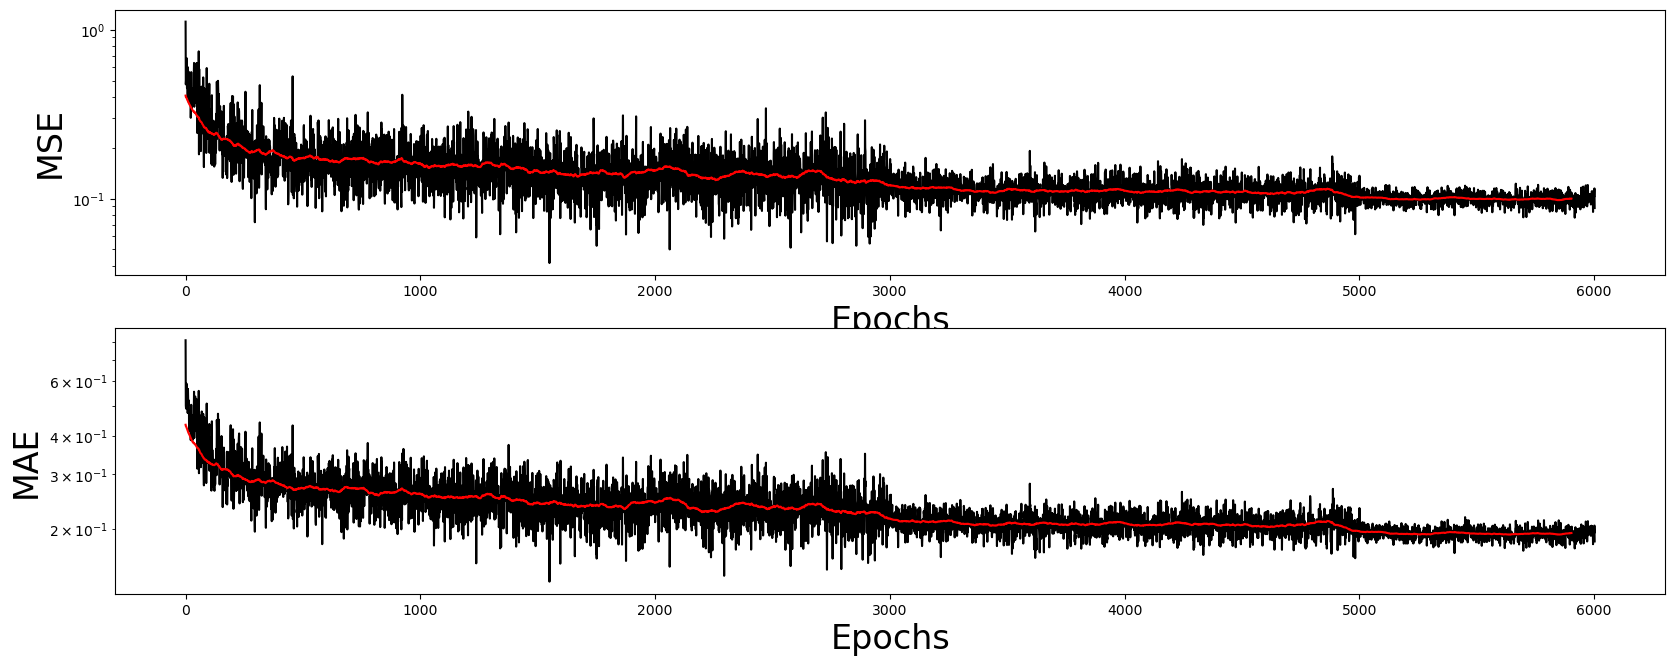

In [16]:
### Plot learning performance
number_of_timesteps_for_average = 100
train_DNN.plot_learning_performance(training_history, number_of_timesteps_for_average)

In [18]:
# average MSE and MAE
avg_mae= round(sum(training_history_LSTM["MAE"])/len(training_history_LSTM["MAE"]), 5)
avg_mse=round(sum(training_history_LSTM["MSE"])/len(training_history_LSTM["MSE"]), 5)
print('MSE: ',avg_mae)
print('MAE: ',avg_mae)

0.2313

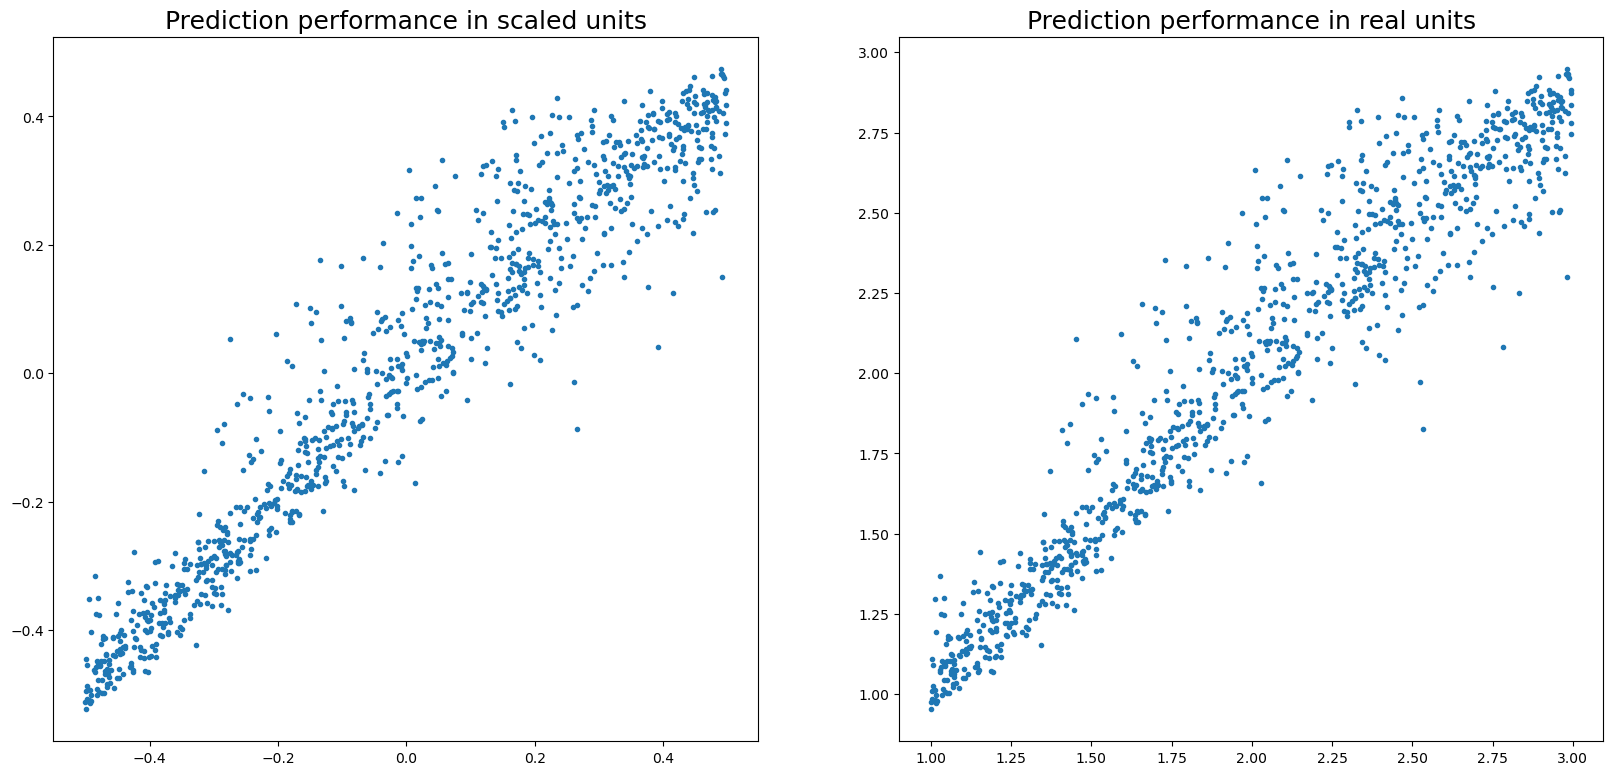

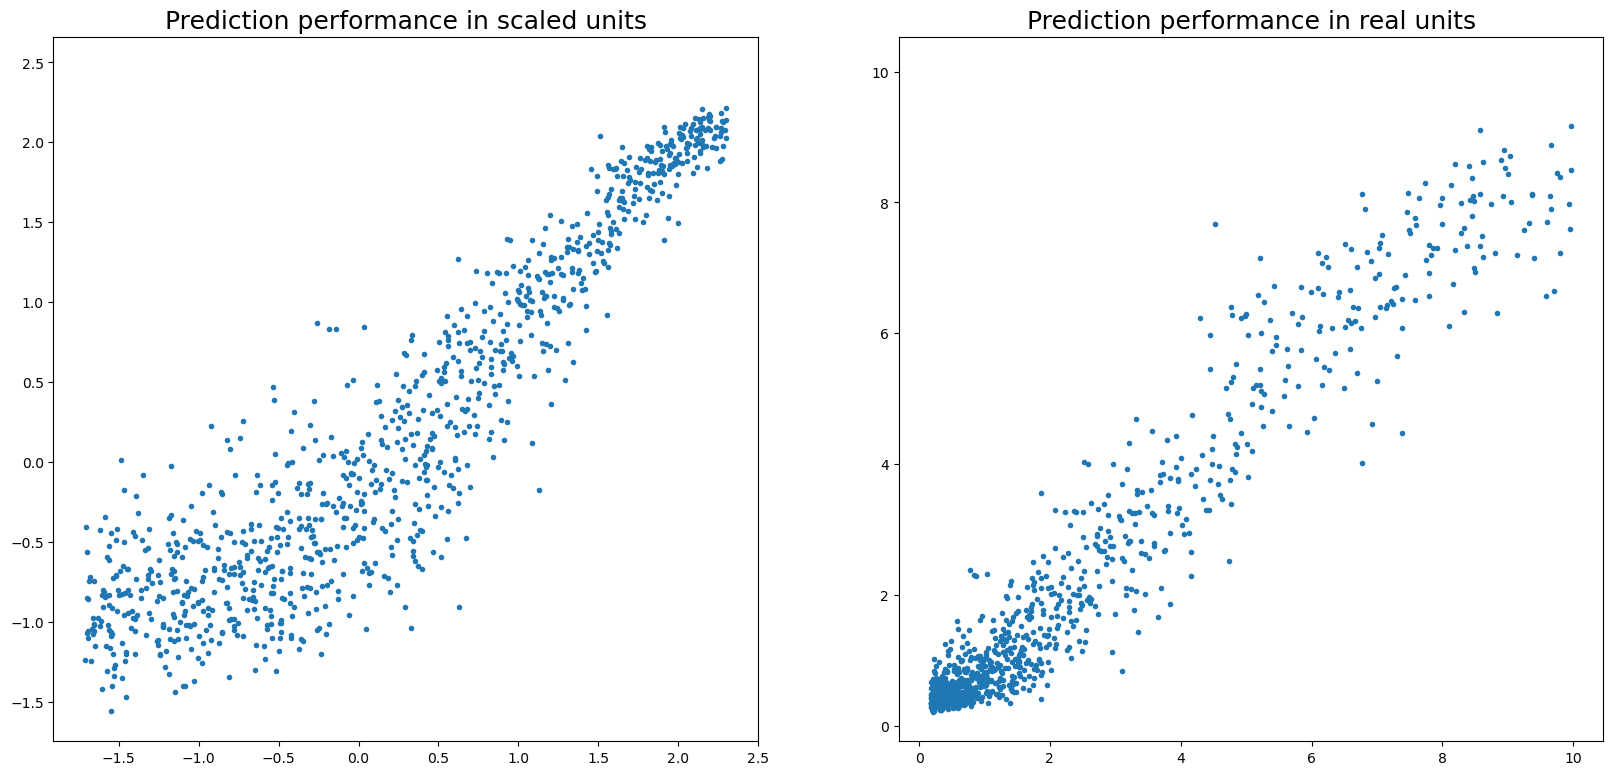

In [17]:
### Plot test performance
test_DNN.plot_test_performance(prediction_test[0], prediction_test[1], prediction_test[2], prediction_test[3], network)